## Part 1. 


In [1]:
# imports
import os
import random
from sklearn.model_selection import train_test_split

from PIL import Image
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score

2025-11-13 20:15:32.829538: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-13 20:15:32.871569: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-13 20:15:32.871623: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-13 20:15:32.873613: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-13 20:15:32.881166: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-13 20:15:32.882026: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# lets start by importing the image libraries. 
damage_dir = "data/damage"
no_damage_dir = "data/no_damage"

In [3]:
# list comprehension to pull every image into one data structure.
damage_images = [os.path.join(damage_dir, f) for f in os.listdir(damage_dir)]
no_damage_images = [os.path.join(no_damage_dir, f) for f in os.listdir(no_damage_dir)]

print(f"# of damage images: {len(damage_images)}")
print(f"# of no-damage images: {len(no_damage_images)}")

# of damage images: 14170
# of no-damage images: 7152


In [4]:
# the idea to use the "random" library was generated by AI, see [1] 
random.seed(42)  

# balance the dataset 
damage_images_balanced = random.sample(damage_images, len(no_damage_images))

# combine both into the new main dataset 
image_paths = damage_images_balanced + no_damage_images
labels = [0]*len(damage_images_balanced) + [1]*len(no_damage_images)

print(f"Total images: {len(image_paths)}")
print(f"Damaged: {labels.count(0)}, Not damaged: {labels.count(1)}")

Total images: 14304
Damaged: 7152, Not damaged: 7152


In [5]:
# shuffle the dataset 
combined = list(zip(image_paths, labels))
random.shuffle(combined)
image_paths, labels = zip(*combined)
image_paths = list(image_paths)
labels = list(labels)


In [6]:
img = Image.open(image_paths[0])
print(img.size) # Get the input dimensions! 

(128, 128)


In [7]:
# Define the three datasets: Training, Validation and Testing. 
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.3, stratify=labels, random_state=42
)


val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")


Train: 10012, Val: 2146, Test: 2146


In [8]:
def load_and_preprocess(path):
    img = Image.open(path).convert("RGB")
    img_array = np.array(img)/255.0  # normalize to [0,1]
    return img_array

# call load for every datapoint
x_train = np.array([load_and_preprocess(p) for p in train_paths])
y_train = np.array(train_labels, dtype=np.float32)

x_val = np.array([load_and_preprocess(p) for p in val_paths])
y_val = np.array(val_labels, dtype=np.float32)

x_test = np.array([load_and_preprocess(p) for p in test_paths])
y_test = np.array(test_labels, dtype=np.float32)

# make sure each image still conforms to the 128 by 128 rule
print("Shapes:", x_train.shape, x_val.shape, x_test.shape)


Shapes: (10012, 128, 128, 3) (2146, 128, 128, 3) (2146, 128, 128, 3)


## Part 2.

In [9]:
# These two lines were generated by AI, see [2]
early = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

def evaluate_model(model, x_test, y_test):
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    y_pred_prob = model.predict(x_test, verbose=0).ravel() # The idea to use .ravel() was generated by AI, see [3]
    return {"loss": loss, "accuracy": acc}

def plot_history(hist, title="Model"):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(hist.history["loss"], label="train_loss")
    plt.plot(hist.history["val_loss"], label="val_loss")
    plt.title(title + " - Loss")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(hist.history.get("accuracy", hist.history.get("acc")), label="train_acc")
    plt.plot(hist.history.get("val_accuracy", hist.history.get("val_acc")), label="val_acc")
    plt.title(title + " - Accuracy")
    plt.legend()
    plt.show()


## Building the ANN. 
Accuracy is not likely going to be high due to lack of spatial awareness. Let's get better than 50% is a good target.

In [10]:
def build_dense_ann(input_shape=(128,128,3)):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),  # flatten first
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(256, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


dense_model = build_dense_ann(x_train.shape[1:])
dense_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 512)               25166336  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 25330689 (96.63 MB)
Trainable params: 2533

## Building the Lenet-5
This is a major improvement on the ANN and is one of the first ever designed CNNs. 
Utilizes convolutional layers to automatically learn spatial features from images. 

In [11]:
from tensorflow.keras import layers, models

def build_lenet5(input_shape=(128,128,3)):
    model = models.Sequential([
        # conv layer
        layers.Conv2D(6, kernel_size=(5,5), activation='tanh', padding='same', input_shape=input_shape),
        layers.AveragePooling2D(pool_size=(2,2), strides=2),  # pool

        # conv layer
        layers.Conv2D(16, kernel_size=(5,5), activation='tanh', padding='valid'),
        layers.AveragePooling2D(pool_size=(2,2), strides=2),  # pool

        # flatten for the conv layers
        layers.Flatten(),

        # fully connected portion
        layers.Dense(120, activation='tanh'),
        layers.Dense(84, activation='tanh'),
        
        # binary classification
        layers.Dense(1, activation='sigmoid')  
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Example usage
lenet_model = build_lenet5(x_train.shape[1:])
lenet_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 6)       456       
                                                                 
 average_pooling2d (Average  (None, 64, 64, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 30, 30, 16)        0         
 gePooling2D)                                                    
                                                                 
 flatten_1 (Flatten)         (None, 14400)             0         
                                                                 
 dense_4 (Dense)             (None, 120)              

## CNN (optimal) 
Follow this architecture from the paper:

- Input 3@(150x150) 0
- 2-D Convolutional 32@(3x3) 32@(148x148) 896
- 2-D Max pooling (2x2) 32@(74x74) 0
- 2-D Convolutional 64@(3x3) 64@(72x72) 18,496
- 2-D Max pooling (2x2) 64@(36x36) 0
- 2-D Convolutional 128@(3x3) 128@(34x34) 73,856
- 2-D Max pooling (2x2) 128@(17x17) 0
- 2-D Convolutional 128@(3x3) 128@(15x15) 147,584
- 2-D Max pooling (2x2) 128@(7x7) 0
- Flattening 1x6272 0
- Dropout 1x6272 0
- Fully connected layer 1x512 3,211,776
- Fully connected layer 1x1 513

In [12]:
from tensorflow.keras import layers, models

def build_best_cnn(input_shape=(128,128,3)):

    # using the paper 
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

best_cnn = build_best_cnn(x_train.shape[1:])
best_cnn.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 128)      

In [14]:
BATCH_SIZE = 32
EPOCHS = 50

Training Dense_ANN...
Epoch 1/50
313/313 - 50s - loss: 1.0522 - accuracy: 0.5157 - val_loss: 0.6732 - val_accuracy: 0.6524 - lr: 0.0010 - 50s/epoch - 158ms/step
Epoch 2/50
313/313 - 48s - loss: 0.6935 - accuracy: 0.4995 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010 - 48s/epoch - 153ms/step
Epoch 3/50
313/313 - 48s - loss: 0.6990 - accuracy: 0.5007 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 0.0010 - 48s/epoch - 153ms/step
Epoch 4/50
313/313 - 47s - loss: 0.6932 - accuracy: 0.4936 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 0.0010 - 47s/epoch - 151ms/step
Epoch 5/50
313/313 - 48s - loss: 0.6932 - accuracy: 0.4952 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 5.0000e-04 - 48s/epoch - 153ms/step
Epoch 6/50
313/313 - 47s - loss: 0.6932 - accuracy: 0.4956 - val_loss: 0.6931 - val_accuracy: 0.5005 - lr: 5.0000e-04 - 47s/epoch - 151ms/step
Evaluating Dense_ANN on test set...
Dense_ANN test results: {'loss': 0.6728569865226746, 'accuracy': 0.6444547772407532}


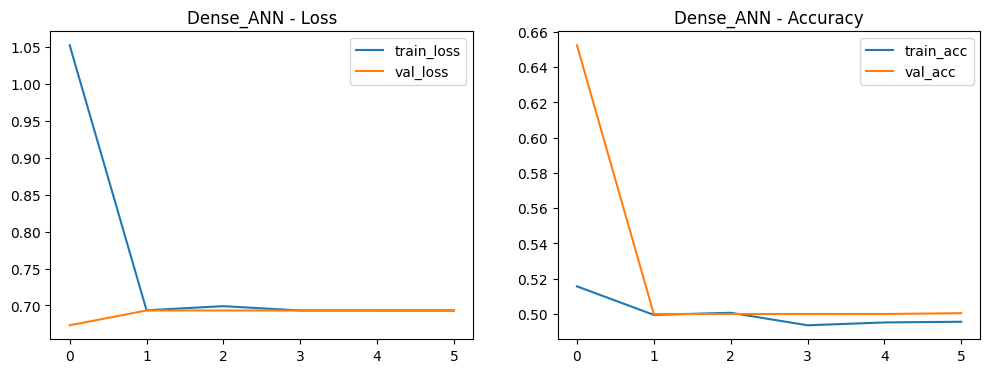

In [20]:
dense_model = build_dense_ann(x_train.shape[1:])
print("Training Dense_ANN...")
hist_dense = dense_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early, reduce_lr],
    verbose=2
)

print("Evaluating Dense_ANN on test set...")
res_dense = evaluate_model(dense_model, x_test, y_test)
print(f"Dense_ANN test results: {res_dense}")
plot_history(hist_dense, title="Dense_ANN")


Training LeNet5...
Epoch 1/50
313/313 - 35s - loss: 0.6341 - accuracy: 0.6425 - val_loss: 0.5162 - val_accuracy: 0.7526 - lr: 0.0010 - 35s/epoch - 113ms/step
Epoch 2/50
313/313 - 33s - loss: 0.5246 - accuracy: 0.7449 - val_loss: 0.4914 - val_accuracy: 0.7689 - lr: 0.0010 - 33s/epoch - 107ms/step
Epoch 3/50
313/313 - 34s - loss: 0.4902 - accuracy: 0.7662 - val_loss: 0.4774 - val_accuracy: 0.7675 - lr: 0.0010 - 34s/epoch - 108ms/step
Epoch 4/50
313/313 - 34s - loss: 0.4384 - accuracy: 0.7971 - val_loss: 0.4885 - val_accuracy: 0.7731 - lr: 0.0010 - 34s/epoch - 108ms/step
Epoch 5/50
313/313 - 34s - loss: 0.3884 - accuracy: 0.8290 - val_loss: 0.4565 - val_accuracy: 0.7815 - lr: 0.0010 - 34s/epoch - 107ms/step
Epoch 6/50
313/313 - 34s - loss: 0.3325 - accuracy: 0.8591 - val_loss: 0.4756 - val_accuracy: 0.7917 - lr: 0.0010 - 34s/epoch - 110ms/step
Epoch 7/50
313/313 - 34s - loss: 0.2511 - accuracy: 0.8984 - val_loss: 0.4832 - val_accuracy: 0.7889 - lr: 0.0010 - 34s/epoch - 108ms/step
Epoch 8/

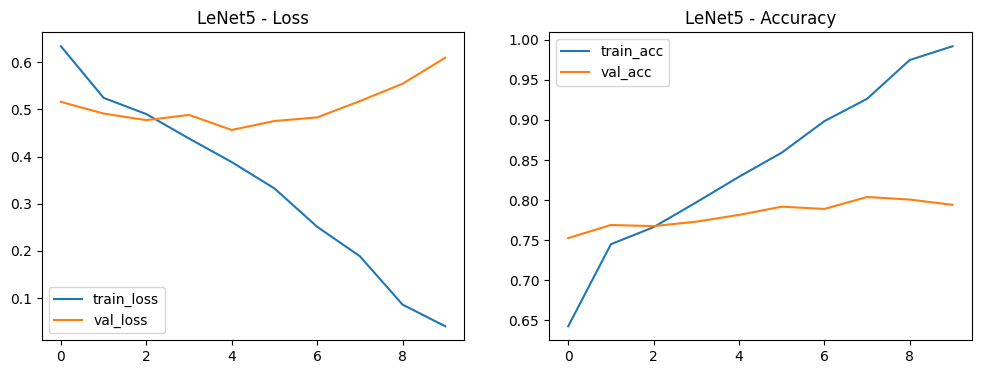

In [16]:
lenet_model = build_lenet5(x_train.shape[1:])
print("Training LeNet5...")
hist_lenet = lenet_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early, reduce_lr],
    verbose=2
)

print("Evaluating LeNet5 on test set...")
res_lenet = evaluate_model(lenet_model, x_test, y_test)
print(f"LeNet5 test results: {res_lenet}")
plot_history(hist_lenet, title="LeNet5")


Training best_cnn...
Epoch 1/50
313/313 - 76s - loss: 0.4317 - accuracy: 0.7833 - val_loss: 0.2100 - val_accuracy: 0.9143 - lr: 0.0010 - 76s/epoch - 244ms/step
Epoch 2/50
313/313 - 75s - loss: 0.2053 - accuracy: 0.9123 - val_loss: 0.1709 - val_accuracy: 0.9329 - lr: 0.0010 - 75s/epoch - 240ms/step
Epoch 3/50
313/313 - 76s - loss: 0.1672 - accuracy: 0.9348 - val_loss: 0.1188 - val_accuracy: 0.9585 - lr: 0.0010 - 76s/epoch - 242ms/step
Epoch 4/50
313/313 - 76s - loss: 0.1342 - accuracy: 0.9481 - val_loss: 0.1869 - val_accuracy: 0.9292 - lr: 0.0010 - 76s/epoch - 244ms/step
Epoch 5/50
313/313 - 76s - loss: 0.1041 - accuracy: 0.9591 - val_loss: 0.1678 - val_accuracy: 0.9371 - lr: 0.0010 - 76s/epoch - 242ms/step
Epoch 6/50
313/313 - 77s - loss: 0.0967 - accuracy: 0.9647 - val_loss: 0.0870 - val_accuracy: 0.9688 - lr: 0.0010 - 77s/epoch - 247ms/step
Epoch 7/50
313/313 - 76s - loss: 0.0849 - accuracy: 0.9685 - val_loss: 0.1311 - val_accuracy: 0.9567 - lr: 0.0010 - 76s/epoch - 243ms/step
Epoch 

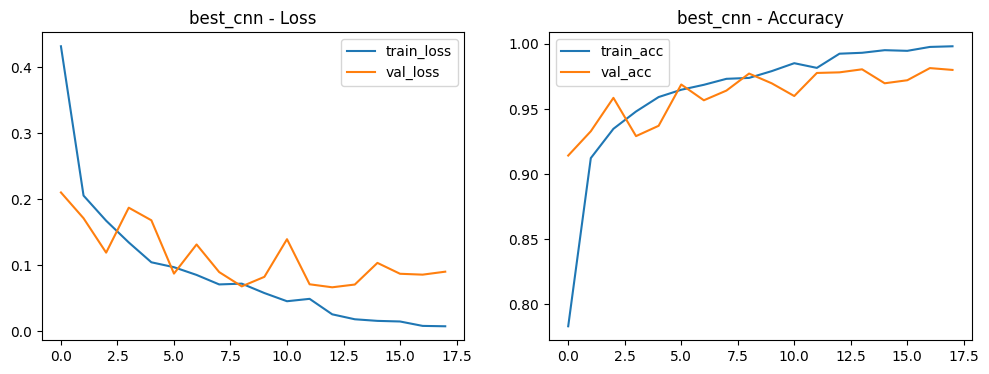

In [17]:
best_cnn_model = build_best_cnn(x_train.shape[1:])
print("Training best_cnn...")
hist_best_cnn = best_cnn_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early, reduce_lr],
    verbose=2
)

print("Evaluating best_cnn on test set...")
res_best_cnn = evaluate_model(best_cnn_model, x_test, y_test)
print(f"best_cnn test results: {res_best_cnn}")
plot_history(hist_best_cnn, title="best_cnn")


## Save the best model!!

In [19]:
best_cnn_model.save("save/best_cnn.keras")